In [1]:
# export environment variables
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import sys

sys.path.insert(0, "./text_detection/src")
sys.path.append("./classification/src")
sys.path.append("./detection/src")
sys.path.append("./text_recognition/src")

import os
import pandas as pd

from classification.core import ClassificationModel
from detection.core import ObjectDetectionModel
from text_recognition.core import TextRecognitionModel
from text_detection.core import TextDetectionModel
from postprocessing.core import Postprocessing



In [238]:
graph_classfication_config = {
    "model_name": "resnet50",
    "n_classes": 5,
    "weights_path": "./weights/graph_classification.pth",
}

x_type_classification_config = {
    "model_name": "resnet50",
    "n_classes": 2,
    "weights_path": "./weights/x_type_classification.pth",
}

y_type_classification_config = {
    "model_name": "resnet50",
    "n_classes": 2,
    "weights_path": "./weights/y_type_classification.pth",
}

keypoint_detection_config = {
    "name": "keypoint_detection",
    "experiment_path": "./detection/src/exps/example/custom/bmga.py",
    "weights_path": "./weights/keypoint_detection.pth",
    "classes": ["value", "x", "y", "x_label", "y_label"],
    "conf_thre": 0.15,
    "nms_thre": 0.25,
    "test_size": (640, 640),
}

text_detection_config = {
    "weights_path": "./weights/synthtext_finetune_ic19_res50_dcn_fpn_dbv2",
    # "config_path": "/home/thanh/shared_disk/thanh/bmga/text_detection/src/experiments/seg_detector/totaltext_resnet50_deform_thre.yaml",
    "config_path": "/home/thanh/shared_disk/thanh/bmga/text_detection/src/experiments/ASF/td500_resnet50_deform_thre_asf.yaml",
    "image_short_side": 2048,
    "thresh": 0.1,
    "box_thresh": 0.05,
    "resize": False,
    "polygon": True,
}

text_recognition_config = {
    "weights_path": "baudm/parseq",
    "model_name": "parseq",
}


# classification_model = ClassificationModel(**graph_classfication_config)
# x_type_classification_model = ClassificationModel(**x_type_classification_config)
# y_type_classification_model = ClassificationModel(**y_type_classification_config)
# keypoint_detection_model = ObjectDetectionModel(**keypoint_detection_config)
text_detection_model = TextDetectionModel(**text_detection_config)
# text_recognition_model = TextRecognitionModel(**text_recognition_config)

verbose: True
Initializing log dir for workspace/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss
Resuming from ./weights/synthtext_finetune_ic19_res50_dcn_fpn_dbv2
Resumed from ./weights/synthtext_finetune_ic19_res50_dcn_fpn_dbv2


In [239]:
image_folder = "./data/validation/images"
image_paths = [os.path.join(image_folder, x) for x in os.listdir(image_folder) if ".jpg" in x][2:3]

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


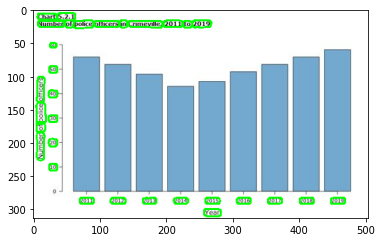

In [240]:
# classification_results = classification_model.predict(image_paths)
# x_type_classification_results = x_type_classification_model.predict(image_paths)
# y_type_classification_results = y_type_classification_model.predict(image_paths)
# keypoint_detection_results = keypoint_detection_model.predict(image_paths)

text_detection_results = text_detection_model.predict(image_paths)
polygons = text_detection_results[0][0][0]
path = image_paths[0]

# visualize
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for polygon in polygons:
    polygon = np.array(polygon).astype(np.int32)
    img = cv2.polylines(img, [polygon], True, (0, 255, 0), 2)

plt.imshow(img)
plt.show()